# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [3]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

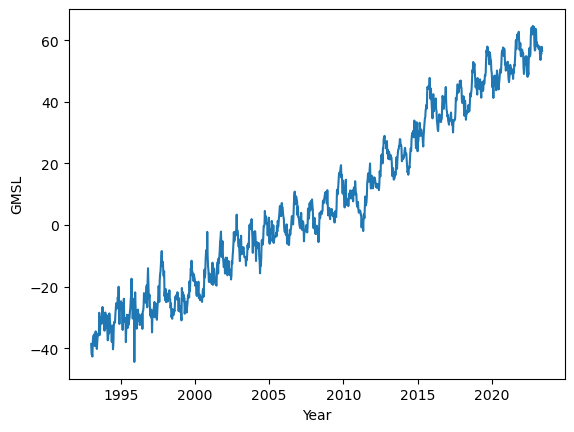

Total Observations: 1119


In [4]:
sealevel = pandas.read_csv("sealevel.csv")
plt.plot(sealevel["Year"], sealevel["GMSL"])
plt.xlabel("Year")
plt.ylabel("GMSL") #Global Mean Sea Level
plt.show()
# number of observations
obs = len(sealevel)
print("Total Observations:", obs)

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** Removing the trend is necessary before fitting an AR model for this data because this data clearly increasing and non-stationary. But for the AR models stationarity(mean and variance) is needed. Statistical properties do not change over time. Trend removing helps to get stationarity. In addition, the AR assumes the error are uncorrelated, if the data has a trend then the errors will be correlated.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

(1119, 1) (1119, 1)


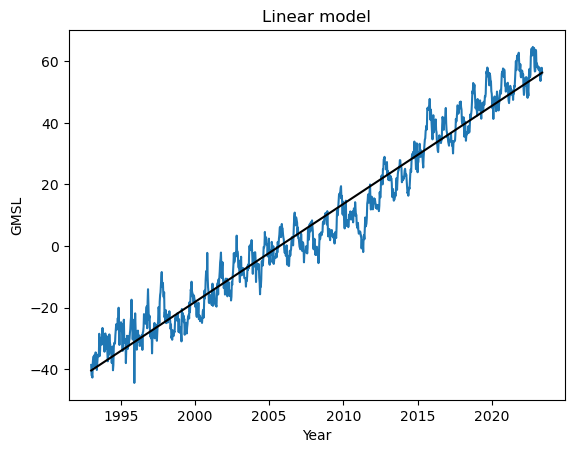

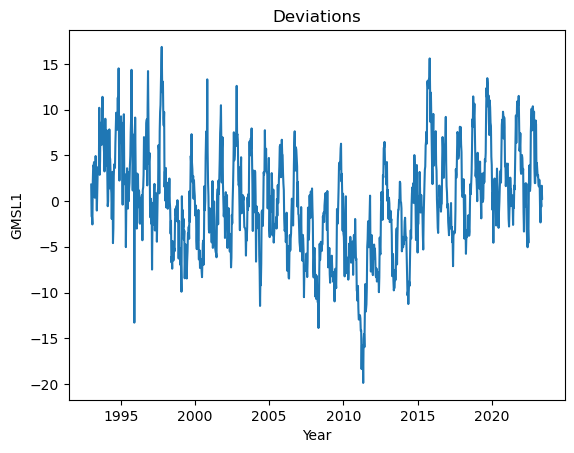

In [5]:
# A3.1
# Reshaping the inputs as is only one feature
Year = np.array(sealevel["Year"])
Year = Year.reshape(-1,1)

GMSL = np.array(sealevel["GMSL"])
GMSL = GMSL.reshape(-1,1)
print(Year.shape,GMSL.shape)

# Fit Linear Regression model
regr = lm.LinearRegression()
regr.fit(Year,GMSL)

# Make prediction and plot the line
y_pred = regr.predict(Year)
plt.plot(Year, GMSL)
plt.plot(Year, y_pred, color="k")
plt.xlabel("Year")
plt.ylabel("GMSL")
plt.xlabel("Year")
plt.title("Linear model")
plt.show()

# A3.2
# deviations(GMSL1) = yt(GMSL) - y_pred
# Detrended data
GMSL1 = GMSL-y_pred
plt.plot(Year, GMSL1)
plt.xlabel("Year")
plt.ylabel("GMSL1")
plt.title("Deviations")
plt.show()

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

(1119, 1)
(700,)
(419, 1)


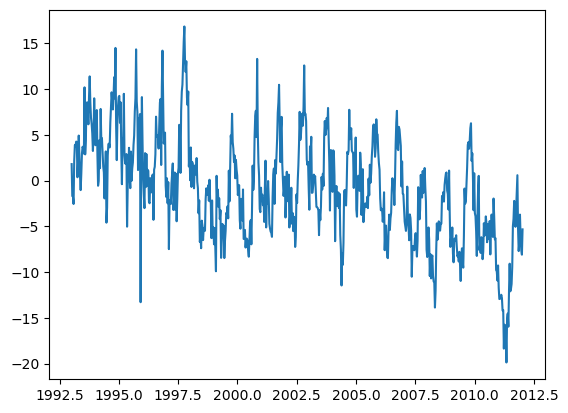

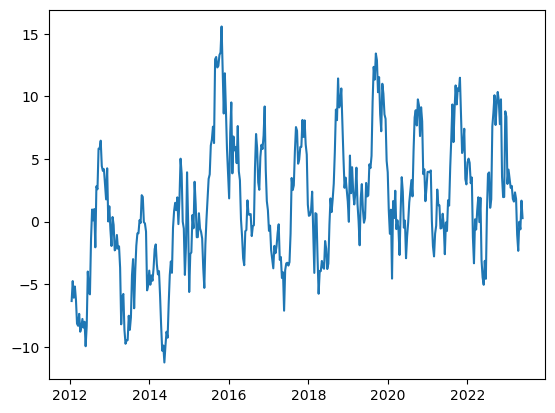

700

In [6]:
# Divide data set

print(GMSL1.shape)

train1 = np.array(GMSL1[0:700])
train = train1.flatten()
print(train.shape)
test1= np.array(GMSL1[700:])
validation= test1.flatten()
print(test1.shape)
plt.plot(Year[0:700],train)
plt.show()
plt.plot(Year[700:], validation)
plt.show()

len(train)

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [7]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y) # <COMPLETE THIS LINE>
    
    # Construct the regression matrix
    Phi = np.zeros((n-p,p)) # <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] = y[(p-j-1):(n-j-1)] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [8]:
#Training a AR(10) 
order = 10
ar_coef = fit_ar(train, order) # y=GMSL_train p=order: parameter
# Check that the first parameter is 1 and the others 0 or close to
print(f'AR({order}) Coefficients:', ar_coef, len(ar_coef))

AR(10) Coefficients: [ 0.63068183  0.1231388   0.12558768  0.17683292 -0.02284342 -0.07140349
 -0.05693816  0.0479181  -0.0893176   0.0251526 ] 10


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [9]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target) # training n= 700
    p = len(theta) # p=10
    
    # Number of steps in prediction
    m = n-p # 700-10 = 690
    y_pred = np.zeros(m) # 0 array of size 690 
    
    for i in range(m): # from 1 to 690
        y_target1 = y_target[i:i+p] # Choose ten previous values
        y_target2 = y_target1[::-1] # reverser array so it fits the linear formula a1y10 + a2y9 + a3y8 + a3y7 
        y_pred[i] = sum(theta*y_target2) # Sum of the product of the parameters theta and the y values 
        
    return y_pred

In [10]:
theta= ar_coef
preds_train= predict_ar_1step(theta,train)
preds_validation= predict_ar_1step(theta,validation)


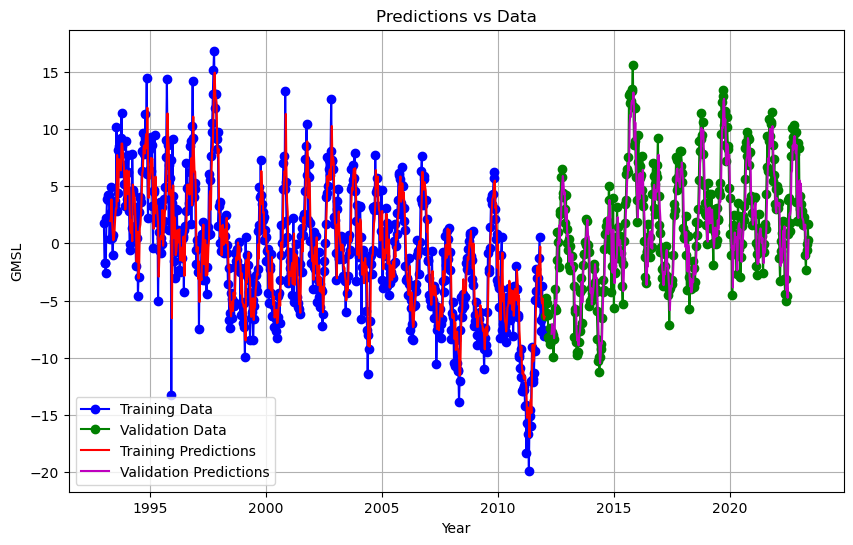

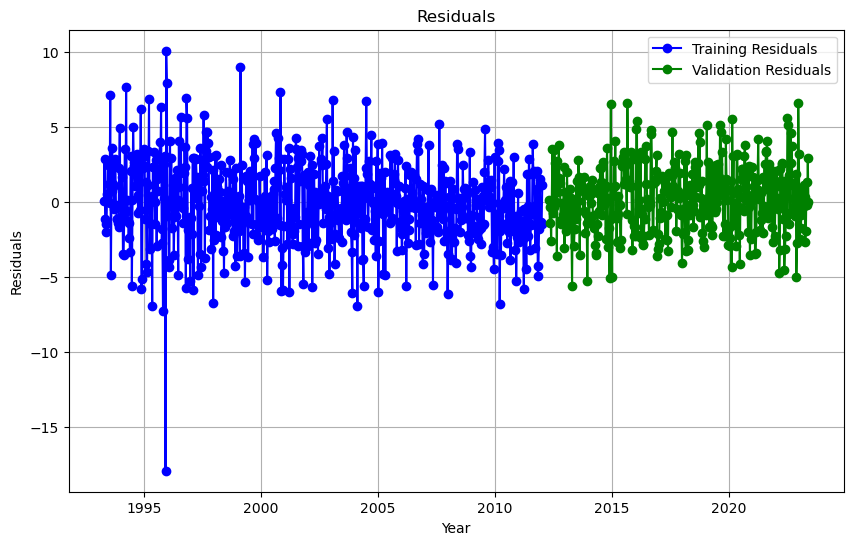

In [11]:
# predictions & data
plt.figure(figsize=(10, 6))
plt.plot(Year[:700],train, marker='o', linestyle='-', color='b', label='Training Data')
plt.plot(Year[700:], validation, marker='o', linestyle='-', color='g', label='Validation Data')
plt.plot(Year[order:700], preds_train, linestyle='-', color='r', label='Training Predictions')
plt.plot(Year[700+order:], preds_validation, linestyle='-', color='m', label='Validation Predictions')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Predictions vs Data')
plt.legend()
plt.grid(True)
plt.show()

# Residuals Part
# Residuals = actual values - predicted values :res are important to see how well the model capturing underlying patterns in data. 
res_train = train[order:] - preds_train
res_val = validation[order:] - preds_validation

plt.figure(figsize=(10, 6))
plt.plot(Year[order:700], res_train, marker='o', linestyle='-', color='b', label='Training Residuals')
plt.plot(Year[700+order:], res_val, marker='o', linestyle='-', color='g', label='Validation Residuals')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.legend()
plt.grid(True)
plt.show()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:** It can be seen that values are positive and negative, which is a type of graph that we could expect if we have some negative parameter "a" on the model, and we have it.
In this case we can see we have some values over the 95% confifence line, which means that this deviate significantly from 0 suggesting that these residual are temporary correlated. If the model is accurate the residuas should be white Gaussian noise. So a model with order p 10, could not be an optimal fit for our data.

In [5]:
help(acfplot)

Help on function acfplot in module tssltools_lab1:

acfplot(x, lags=None, conf=0.95)
    Plots the empirical autocorralation function.
    
    :param x: array (n,), sequence of data points
    :param lags: int, maximum lag to compute the ACF for. If None, this is set to n. Default is None.
    :param conf: float, number in the interval [0,1] which specifies the confidence level (based on a central limit
                 theorem under a white noise assumption) for two dashed lines drawn in the plot. Default is 0.95.
    :return:



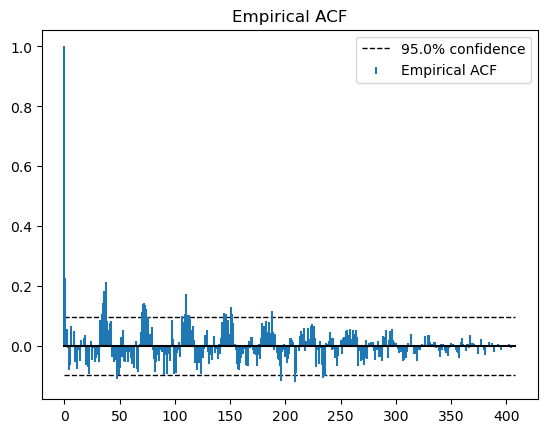

In [12]:
acfplot(res_val)

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

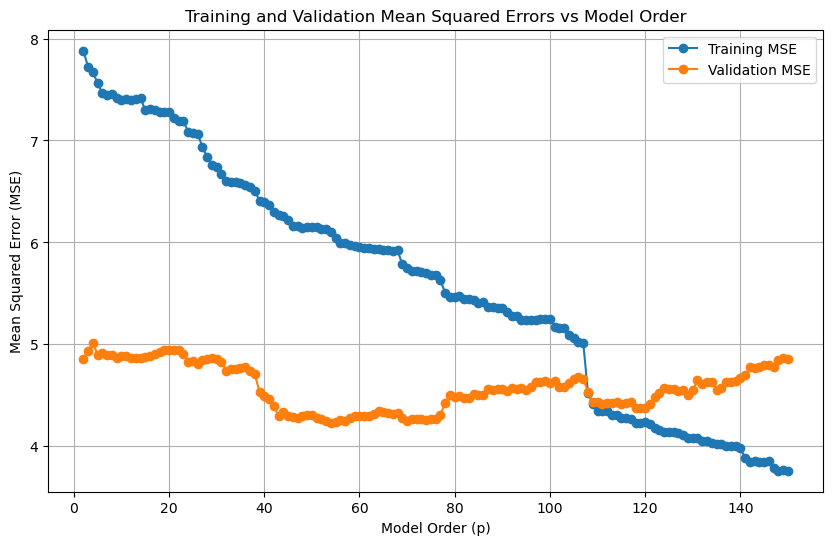

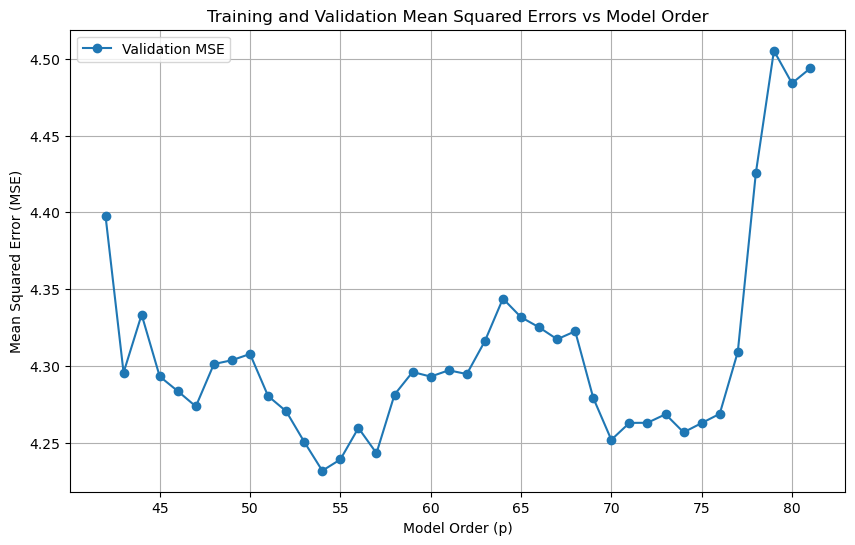

In [13]:
ps = np.arange(2,151, 1) # Array of p (order)
train_MSE = np.zeros(len(ps))
validation_MSE = np.zeros(len(ps))
w =0

for p in ps:
    
    thetas = fit_ar(train, p) # Parameters a's
    
    predictions = predict_ar_1step(thetas,np.concatenate((train, validation)))
    #print(len(predictions), len(train),len(validation), len(predictions[p:700]), len(train[p:]) ,len(predictions[700-p:]))
    train_MSE[w]= np.mean((train[p:]-predictions[:700-p])**2)
    validation_MSE[w]= np.mean((validation-predictions[700-p:])**2)
    w = w + 1

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.plot(ps, train_MSE, marker='o', label='Training MSE')
plt.plot(ps,  validation_MSE, marker='o', label='Validation MSE')
plt.xlabel('Model Order (p)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation Mean Squared Errors vs Model Order')
plt.legend()
plt.grid(True)
plt.show()

# Zoom in
# Plotting the errors
plt.figure(figsize=(10, 6))
plt.plot(ps[40:80],  validation_MSE[40:80], marker='o', label='Validation MSE')
plt.xlabel('Model Order (p)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation Mean Squared Errors vs Model Order')
plt.legend()
plt.grid(True)
plt.show()

What is the main difference between the changes in training error and validation error as the order increases?

**Answer:**

As the order increases, the training error is higher than the validation error and it decreases over time. This behaviour is quite unusual comparing the normal data set
we have been working on, in other ML lectures. As for the validation error, it is smaller than the training error at the begining, then it decreased from order 40 to 80 and then it increases.
Around the oreder 110, the errors starts to show that the model is overfitting, as the validation error starts increasing and the training is going towards zero.

Based on these results, which model order would you suggest to use and why?

**Answer:**

Our first though was to select the model order of 110, where the intersection of both erros happened, as we though is where the model relfects better perfomance on both data sets. But selecting this model order could mean to be on the edge of overfitting, so at the end we conclude to selected a model order between 40 and 80. After taking a closer look to the validation error between 40 and 80 order,
we noticed that difference between the lowest MSE with order 54 and the MSE with order 42 is less than 0.20, so w eselected the model of smaller order,42, to have a less complex model and avoid overfitting.


**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

**Answer:**

In comparison with the ACF plot with order 10, the ACF plot with order 42 do not have pattern like a sin functions. It can be seen that less values are over the 95% confidence line, which suggestesa better order selection than a p=10, but it still a little it far from ideal. As we should be looking to have zero lines over the 95% confidence line, to confirm that the residuals are temporary uncorrelated.

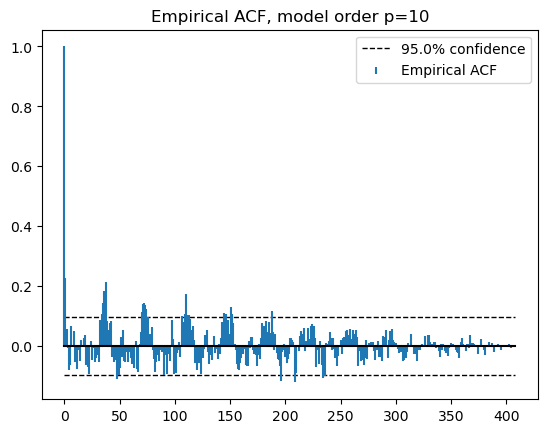

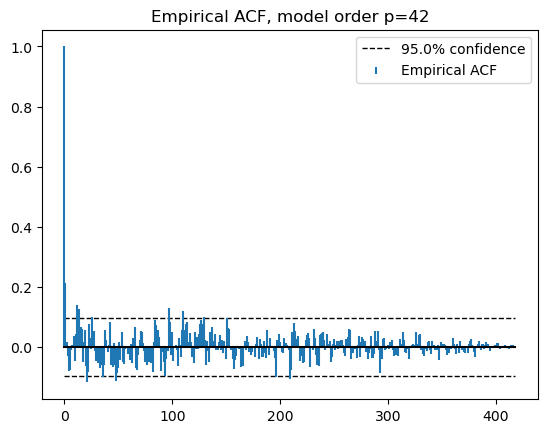

In [14]:
p_choosen=42
thetas42 = fit_ar(train, p_choosen)
predictions42 = predict_ar_1step(thetas42,np.concatenate((train, validation)))

# Residuals Part
# Residuals = actual values - predicted values :res are important to see how well the model capturing underlying patterns in data. 
res_train42 = train[p_choosen:] - predictions42[:700-p_choosen]
res_val42 = validation - predictions42[700-p_choosen:]


acfplot(res_val)
plt.title("Empirical ACF, model order p=10")
plt.show()
acfplot(res_val42)
plt.title("Empirical ACF, model order p=42")

plt.show()

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [15]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point

    for i in range(m):
        y_sim[i] = sum(theta*phi[:p]) # sum of p previous predictions or known values
        phi = np.append(y_sim[i], phi) # Update phi array with the predicted value at step i of m
    
    return y_sim#, len(phi), phi[], y, len(y_sim)
    

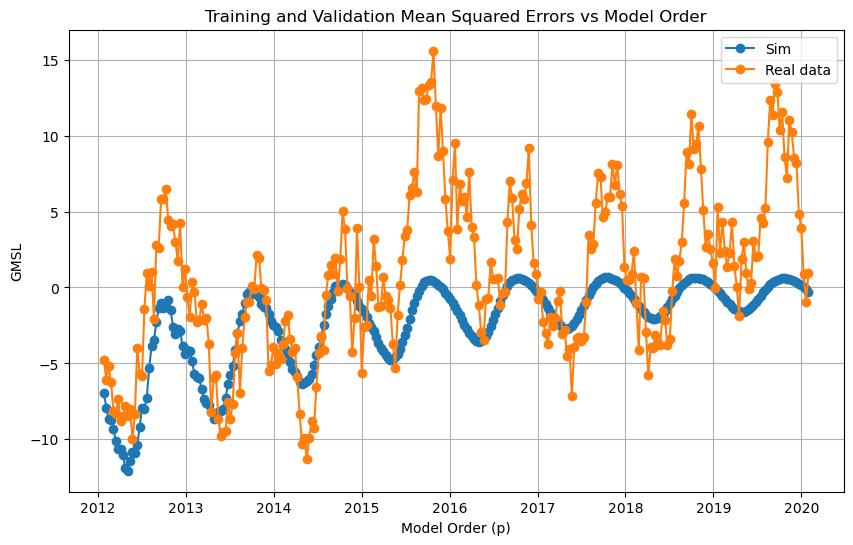

In [16]:
y = GMSL1[0:700].flatten()
m = 296
theta = thetas42
y_700_997 = simulate_ar(y,theta,m)

plt.figure(figsize=(10, 6))
plt.plot(Year[701:997], y_700_997, marker='o', label='Sim')
plt.plot(Year[701:997], GMSL1[701:997], marker='o', label='Real data')
plt.xlabel('Model Order (p)')
plt.ylabel('GMSL')
plt.title('Training and Validation Mean Squared Errors vs Model Order')
plt.legend()
plt.grid(True)
plt.show()

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

As first impression, this do not appear as something we would expect. We expected that our parameters
first estimated, would mantain a good generalization of the model, but from the result plotted this do not seem to hold.

Explination:

When simulating a large number of m steps ahead, the past values become less relevant or less correlated
to the future values. Because the time series reached a steady state, in this steady state the mean and variance remain constant, and the time series will predict the mean of the time series, that will be zero in this state.


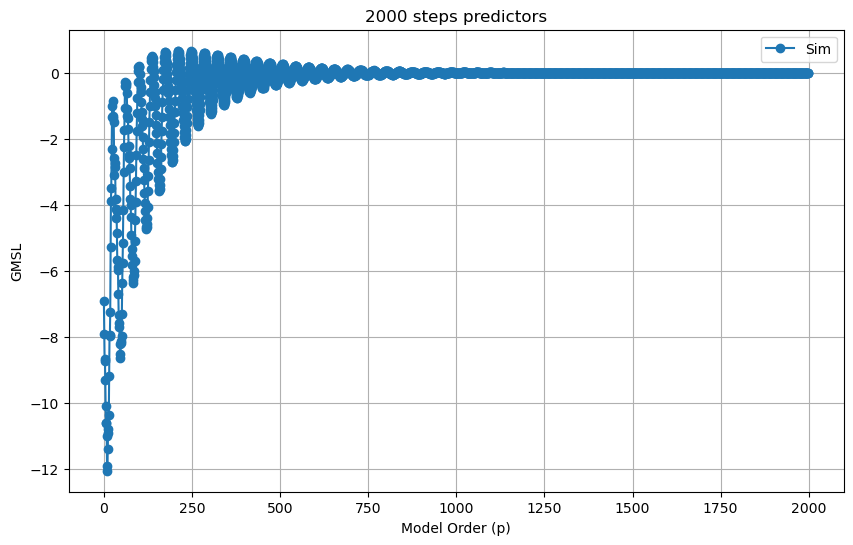

In [17]:
y_701_2700 = simulate_ar(y,theta,2000)
plt.figure(figsize=(10, 6))
plt.plot( y_701_2700, marker='o', label='Sim')
plt.xlabel('Model Order (p)')
plt.ylabel('GMSL')
plt.title('2000 steps predictors')
plt.legend()
plt.grid(True)
plt.show()

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [18]:
def nar_model(p,y,layers,act,solver, maxiter):
    ''' Simulates a NAR(p) model
    p = order of the model
    m = steps ahead to make the prediction
    act_func = activation function of the MLP Regressor
    nl= number of hidden layers
    '''
    # Train the MLPRegressor
     # Number of training data points
    n = len(y) # <COMPLETE THIS LINE>
    
    # Construct the regression matrix
    Phi = np.zeros((n-p,p)) # <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] = y[(p-j-1):(n-j-1)] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    model = MLPRegressor(hidden_layer_sizes=layers, 
                         activation= act,solver= solver, max_iter=maxiter)
    model.fit(Phi,yy)   
    
    m = n-p
    y_pred = np.zeros(m)
    phi = np.flip(y[-p:].copy())
    phi = phi.reshape((1,p)) #important to reshape, predict expect shape (1,42) not (42,1)        
    
    for i in range(m):
        y_pred[i] = model.predict(phi[:,:p])
        phi = np.append(y_pred[i], phi)
        phi = phi.reshape((1,len(phi)))
        
        
    return y_pred


C:\Users\act_9\miniconda3\envs\tssl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


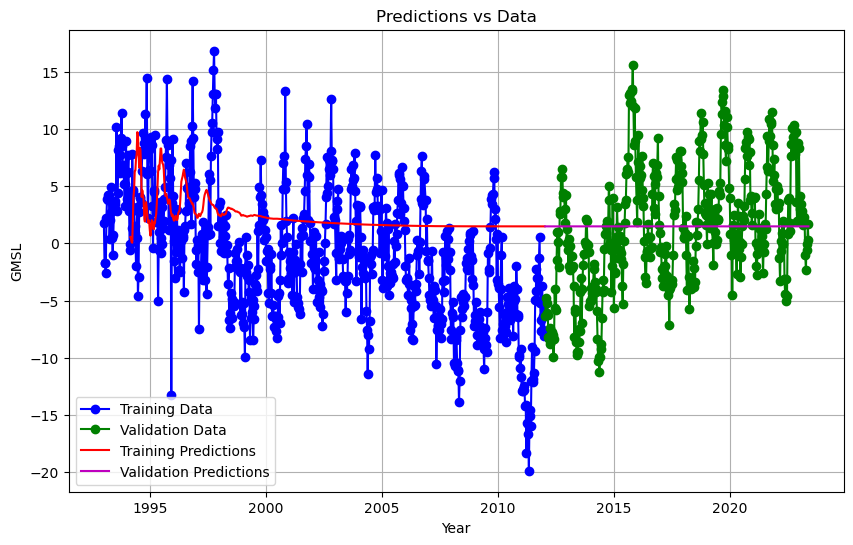

(658,) (658, 1) (419, 1) (419,)


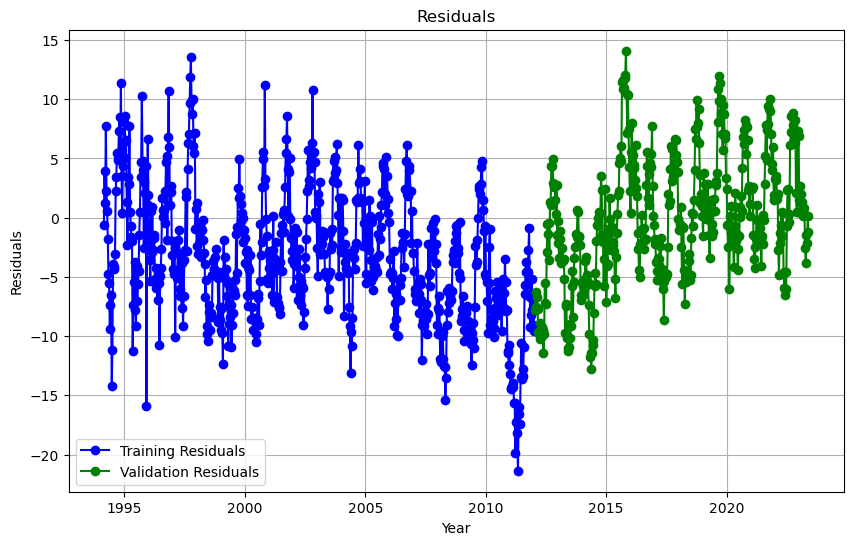

In [22]:
#y = GMSL1[0:700].flatten()
y= np.concatenate((train, validation))
p=42
y700_997=nar_model(p, y,(10,),'relu' ,'adam',200)
# predictions & data
plt.figure(figsize=(10, 6))
plt.plot(Year[:700],train, marker='o', linestyle='-', color='b', label='Training Data')
plt.plot(Year[700:], validation, marker='o', linestyle='-', color='g', label='Validation Data')
plt.plot(Year[p:700], y700_997[:700-p], linestyle='-', color='r', label='Training Predictions')
plt.plot(Year[700:], y700_997[700-p:], linestyle='-', color='m', label='Validation Predictions')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Predictions vs Data')
plt.legend()
plt.grid(True)
plt.show()

# Residuals Part
# Residuals = actual values - predicted values :res are important to see how well the model capturing underlying patterns in data. 
res_train= train[p:] - y700_997[:700-p]
res_val = validation - y700_997[700-p:]

print(res_train.shape, Year[p:700].shape, Year[700:].shape, res_val.shape)
plt.figure(figsize=(10, 6))
plt.plot(Year[p:700], res_train, marker='o', linestyle='-', color='b', label='Training Residuals')
plt.plot(Year[700:], res_val, marker='o', linestyle='-', color='g', label='Validation Residuals')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.legend()
plt.grid(True)
plt.show()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

By looking at the residuals we can see that the time series is not stationar, which could have an inference on the underfitting of our predictions. Perhaps, another pre processing method appart from the extraction the of the fitted line, from the regression, from the original data is needed.
The MLP network is not deep enough to be able to learns complex patterns of this data set. Or a more addecuate architecture of neural network as a Convolutional neural network could learn to extract better more complex patterns of the time series.



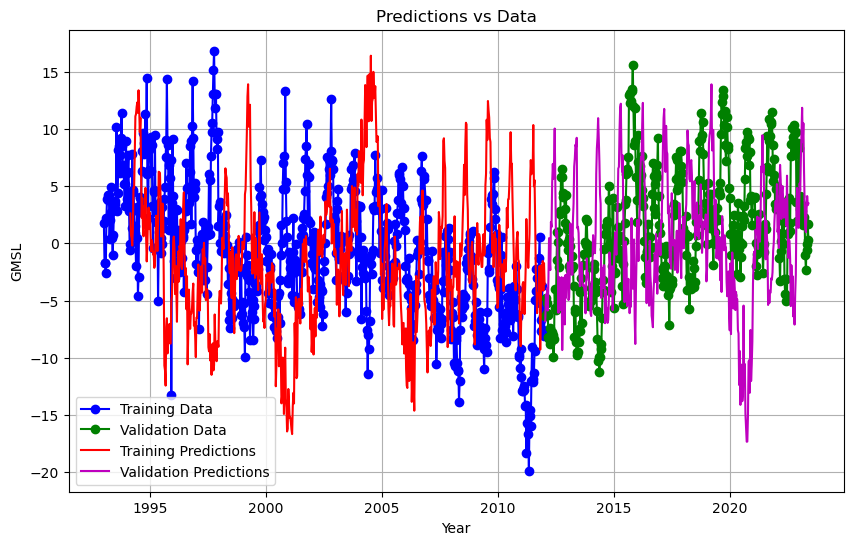

(658,) (658, 1) (419, 1) (419,)


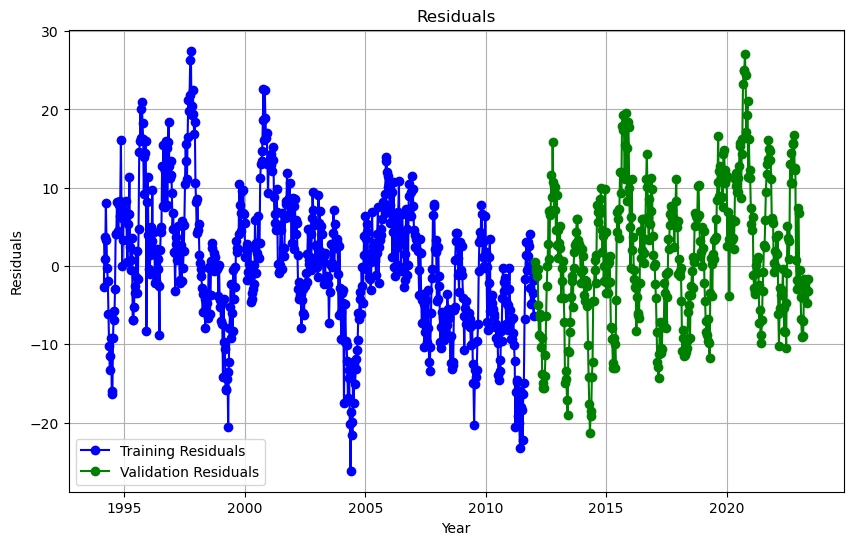

In [25]:
y= np.concatenate((train, validation))
p=42
y700_997=nar_model(p, y, (42,84,120,42),'tanh','lbfgs', 1800)
# predictions & data
plt.figure(figsize=(10, 6))
plt.plot(Year[:700],train, marker='o', linestyle='-', color='b', label='Training Data')
plt.plot(Year[700:], validation, marker='o', linestyle='-', color='g', label='Validation Data')
plt.plot(Year[p:700], y700_997[:700-p], linestyle='-', color='r', label='Training Predictions')
plt.plot(Year[700:], y700_997[700-p:], linestyle='-', color='m', label='Validation Predictions')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Predictions vs Data')
plt.legend()
plt.grid(True)
plt.show()

# Residuals Part
# Residuals = actual values - predicted values :res are important to see how well the model capturing underlying patterns in data. 
res_train= train[p:] - y700_997[:700-p]
res_val = validation - y700_997[700-p:]

print(res_train.shape, Year[p:700].shape, Year[700:].shape, res_val.shape)
plt.figure(figsize=(10, 6))
plt.plot(Year[p:700], res_train, marker='o', linestyle='-', color='b', label='Training Residuals')
plt.plot(Year[700:], res_val, marker='o', linestyle='-', color='g', label='Validation Residuals')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.legend()
plt.grid(True)
plt.show()